In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sunraster.instr.spice import read_spice_l2_fits
import h5py
import sunpy 
import sunpy.map
from correct_2d_psf import get_fwd_matrices, correct_spice_raster
from util import bindown, as_dict, get_iris_data, masked_median_filter, get_mask_errs
from fit_spice_lines import get_overall_center, fit_spice_lines as fsl
import astropy
from astropy.visualization import (ImageNormalize, AsinhStretch)
from astropy import constants as const
import juanfit
import importlib
importlib.reload(juanfit)
from juanfit import SpectrumFit2D

from copy import deepcopy

/home/yjzhu/spice_psf/util.py:37: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(fastmath=True, parallel=True)


In [2]:
spice_raster = read_spice_l2_fits("../src/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000.fits")

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


In [3]:
spice_raster.keys()

dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'N IV 765 - Peak', 'Ne VIII 770 - Peak', 'S V 786 / O IV 787 (Merged)', 'N III 991 (Merged)'])

In [4]:
spice_NIV_765_window = spice_raster["N IV 765 - Peak"]

In [5]:
spice_NIV_765_window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'WAVE' 'TIME' 
CRVAL : 0.29494045034444444 0.12210741052555556 7.647598670000001e-08 5783.875 
CRPIX : 96.5 416.5 25.5 1.0 
PC1_1 PC1_2 PC1_3 PC1_4  : 0.996644433832 -0.0224685795869 0.0 0.0 
PC2_1 PC2_2 PC2_3 PC2_4  : 0.298188520767 0.996644433832 0.0 0.0 
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0 0.0 1.0 0.0 
PC4_1 PC4_2 PC4_3 PC4_4  : -60.25 0.0 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 9.751700000000001e-12 1.0 
NAXIS : 192  832  50  1

In [6]:
spice_NIV_765_window.data.shape

(1, 50, 832, 192)

In [7]:
NIV_765_window_rebin = spice_NIV_765_window.rebin((1,50,1,1))[0,0,:,:]

In [8]:
NIV_765_window_int_map = sunpy.map.Map(NIV_765_window_rebin.data, NIV_765_window_rebin.meta)

In [9]:
NIV_765_window_int_map.plot_settings['cmap'] = 'viridis'
NIV_765_window_int_map.plot_settings['aspect'] = NIV_765_window_int_map.scale.axis2/NIV_765_window_int_map.scale.axis1
NIV_765_window_int_map.plot_settings['norm'] = ImageNormalize(stretch=AsinhStretch(0.1))

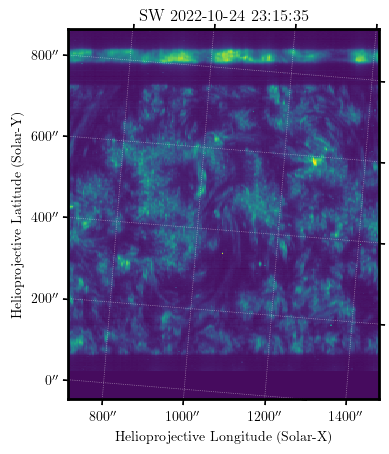

In [10]:
NIV_765_window_int_map.plot()

In [11]:
spice_dat = deepcopy(spice_NIV_765_window.data[0])
specmin = np.nanmin(spice_NIV_765_window.data[0], axis=2)
spice_dat = spice_dat - specmin[:,:,np.newaxis]
spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,36:42],:,:], axis=0)[np.newaxis,:,:]

/tmp/ipykernel_155683/3464076325.py:2: RuntimeWarning: All-NaN slice encountered
  specmin = np.nanmin(spice_NIV_765_window.data[0], axis=2)
/tmp/ipykernel_155683/3464076325.py:4: RuntimeWarning: All-NaN slice encountered
  spice_dat = spice_dat - np.nanmedian(spice_dat[np.r_[12:18,36:42],:,:], axis=0)[np.newaxis,:,:]


In [12]:
spice_dat.shape

(50, 832, 192)

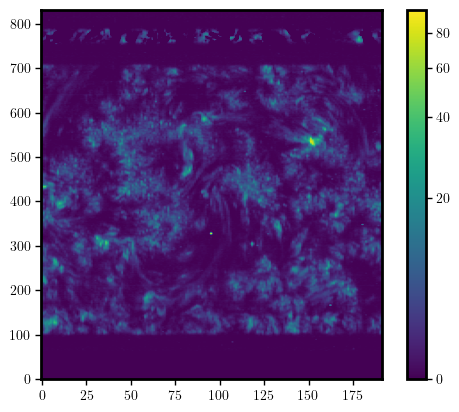

In [13]:
plt.imshow(np.nansum(spice_dat, axis=0)[:,:],origin="lower",norm=ImageNormalize(vmin=0,stretch=AsinhStretch(0.1)),
           aspect=1/4)
plt.colorbar()

In [14]:
spice_hdr = spice_NIV_765_window.meta.original_header
# This exponent sets the non-gaussianity of the PSF core, 1 = Gaussian
# It also also changes its width somewhat, which is not ideal...
yl_core_xpo = 1.5

# Rotation angle of the PSF, both core and wings
psf_yl_angle = -15*np.pi/180

# FWHMs of PSF core. First argument is width along y axis before rotation,
# and is in arcseconds. Second is along lambda axis and is in angstrom.
fwhm_core0_yl = np.array([2, 0.95])

# This descriptor for plots should be manually edited to reflect the PSF parameters
gaussian_desc = '2-part Gaussian PSF'

fwhm_wing0_yl = np.array([10.0, 2.5]) # FWHMs of PSF wings in arcseconds and angstroms, respectively
desc_str='; standard wing aspect ratio'

# Fraction of overall PSF amplitude in wings (core weight is 1.0 - wing_weight).
# PSFs have unit peak amplitude, -- PLEASE NOTE: they do not integrate to 1.
wing_weight = 0.2



In [15]:
spice_hdr["NBIN1"], spice_hdr["NBIN2"], spice_hdr["NBIN3"]

(1, 1, 1)

In [16]:
rebin_facs = [1,4,1]

In [17]:
spice_dat.shape

(50, 832, 192)

In [18]:
spicedat_bindown = bindown(spice_dat[:,120:700,:],np.round(np.array(spice_dat[:,120:700,:].shape)/rebin_facs).astype(np.int32))
spicedat_bindown.shape

(50, 145, 192)

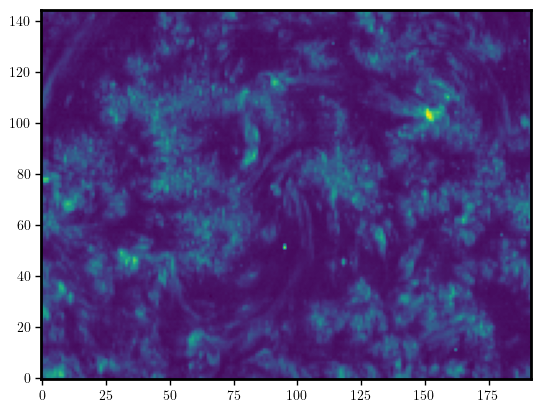

In [19]:
plt.imshow(np.nansum(spicedat_bindown, axis=0)[:,:],origin="lower",norm=ImageNormalize(stretch=AsinhStretch(0.1)),
              aspect=1)

/tmp/ipykernel_155683/3092382005.py:1: RuntimeWarning: invalid value encountered in power
  plt.imshow((np.nansum(spicedat_bindown[:,5:30,180:195], axis=0)**(1./2.2)),origin="lower",aspect=1)


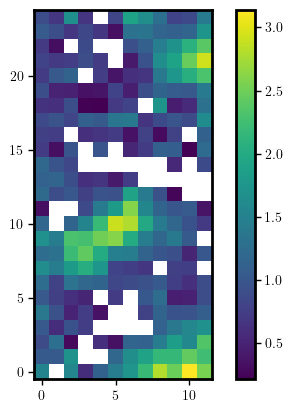

In [20]:
plt.imshow((np.nansum(spicedat_bindown[:,5:30,180:195], axis=0)**(1./2.2)),origin="lower",aspect=1)
plt.colorbar()

In [21]:
spice_err_fac = np.nanstd(spicedat_bindown[:,5:30,180:195])

In [22]:
# spicedat_bindown = spicedat_bindown - np.nanmedian(spicedat_bindown[:,125:175,0:25])

In [23]:
spice_dat1 = deepcopy(spicedat_bindown).transpose([2,1,0]).astype(np.float32)

In [24]:
spice_corr_dat, spice_corr_chi2s, metadict = correct_spice_raster(spice_dat1, spice_hdr, fwhm_core0_yl, fwhm_wing0_yl, psf_yl_angle, wing_weight,
                                                                    yl_core_xpo=yl_core_xpo,super_fac=1, psf_thold_core=0.0005, spice_bin_facs=rebin_facs,)

Correcting N IV 765 - Peak; ref. wavelength=762.2731835000001
Computing PSF Core:
4.979997240998759 % done after 0.4437835216522217 seconds
9.97378948820527 % done after 0.884246826171875 seconds
14.96758173541178 % done after 1.3344080448150635 seconds
19.96137398261829 % done after 1.7711033821105957 seconds
24.955166229824805 % done after 2.2027339935302734 seconds
29.948958477031315 % done after 2.628944158554077 seconds
34.942750724237825 % done after 3.0538291931152344 seconds
39.93654297144434 % done after 3.4751791954040527 seconds
44.930335218650846 % done after 3.8997912406921387 seconds
49.92412746585736 % done after 4.324534177780151 seconds
54.917919713063874 % done after 4.761615037918091 seconds
59.91171196027038 % done after 5.202556610107422 seconds
64.9055042074769 % done after 5.748147487640381 seconds
69.89929645468341 % done after 6.267028331756592 seconds
74.89308870188992 % done after 6.7526373863220215 seconds
79.88688094909642 % done after 7.241797924041748 sec

/home/yjzhu/spice_psf/util.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/spice_psf/util.py (40)

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

  @numba.jit(fas

Correcting the PSF:
7.323864698410034 s; Finished slit index 0 of 192 29 of 40 iterations taken, chi^2= 0.10664391780890921
14.007992267608643 s; Finished slit index 1 of 192 27 of 40 iterations taken, chi^2= 0.10383846816515635
20.641209840774536 s; Finished slit index 2 of 192 25 of 40 iterations taken, chi^2= 0.11433985533245768
28.558363914489746 s; Finished slit index 3 of 192 28 of 40 iterations taken, chi^2= 0.06526440057307875
33.681395292282104 s; Finished slit index 4 of 192 20 of 40 iterations taken, chi^2= 0.06434822248085835
41.35814571380615 s; Finished slit index 5 of 192 29 of 40 iterations taken, chi^2= 0.08733630019827329
46.25068283081055 s; Finished slit index 6 of 192 20 of 40 iterations taken, chi^2= 0.09431231688523121
51.01172471046448 s; Finished slit index 7 of 192 22 of 40 iterations taken, chi^2= 0.09793024533390887
57.556406021118164 s; Finished slit index 8 of 192 29 of 40 iterations taken, chi^2= 0.09090640239076421
64.23479676246643 s; Finished slit inde

In [25]:
spice_sdev_guess = 0.1
corr_sdev_guess = 0.05


spice_mask, spice_err = get_mask_errs(spice_dat1.astype(np.float64), spice_err_fac)
spice_corr_mask, spice_corr_err = get_mask_errs(spice_corr_dat, spice_err_fac)

[det_origin0, det_dims0, det_scale0] = metadict["det_origin0"], metadict["det_dims0"], metadict["det_scale0"]
spice_la = spice_NIV_765_window.spectral_axis.to_value("Angstrom")
spice_wlcen0 = spice_la[np.nanargmax(np.nanmean(spice_dat1[:,:,:], axis=(0,1)))]

/home/yjzhu/spice_psf/util.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_masked_medfilt_inner" failed type inference due to: Use of unsupported NumPy function 'numpy.unravel_index' or unsupported use of the function.

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

During: typing of get attribute at /home/yjzhu/spice_psf/util.py (40)

File "../../../spice_psf/util.py", line 40:
def _masked_medfilt_inner(flatinds,data,footprint_inds,footprint_ind_offset,tparg,dat_pad_shape,data_fppad,mask_fppad,data_filt):
    <source elided>
    for ind in flatinds:
        ijkpad = np.unravel_index(ind,data.shape)+footprint_inds-footprint_ind_offset
        ^

  @numba.jit(fas

In [26]:
spice_fits = fsl(spice_dat1, spice_err, spice_la, spice_mask, spice_wlcen0, spice_sdev_guess)

spice_corr_fits = fsl(spice_corr_dat, spice_corr_err, spice_la, spice_corr_mask, spice_wlcen0, corr_sdev_guess)

0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0
0 of 192 0.0
10 of 192 0.0
20 of 192 0.0
30 of 192 0.0
40 of 192 0.0
50 of 192 0.0
60 of 192 0.0
70 of 192 0.0
80 of 192 0.0
90 of 192 0.0
100 of 192 0.0
110 of 192 0.0
120 of 192 0.0
130 of 192 0.0
140 of 192 0.0
150 of 192 0.0
160 of 192 0.0
170 of 192 0.0
180 of 192 0.0
190 of 192 0.0
191 of 192 0.0


In [27]:
spice_origin_vel = (spice_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_origin_vel = spice_origin_vel - np.nanmedian(spice_origin_vel[:,:])

spice_corr_vel = (spice_corr_fits["centers"].T/spice_wlcen0 - 1)*const.c.to_value("km/s")
spice_corr_vel = spice_corr_vel - np.nanmedian(spice_corr_vel[:,:])

Text(0.5, 1.0, 'Corrected')

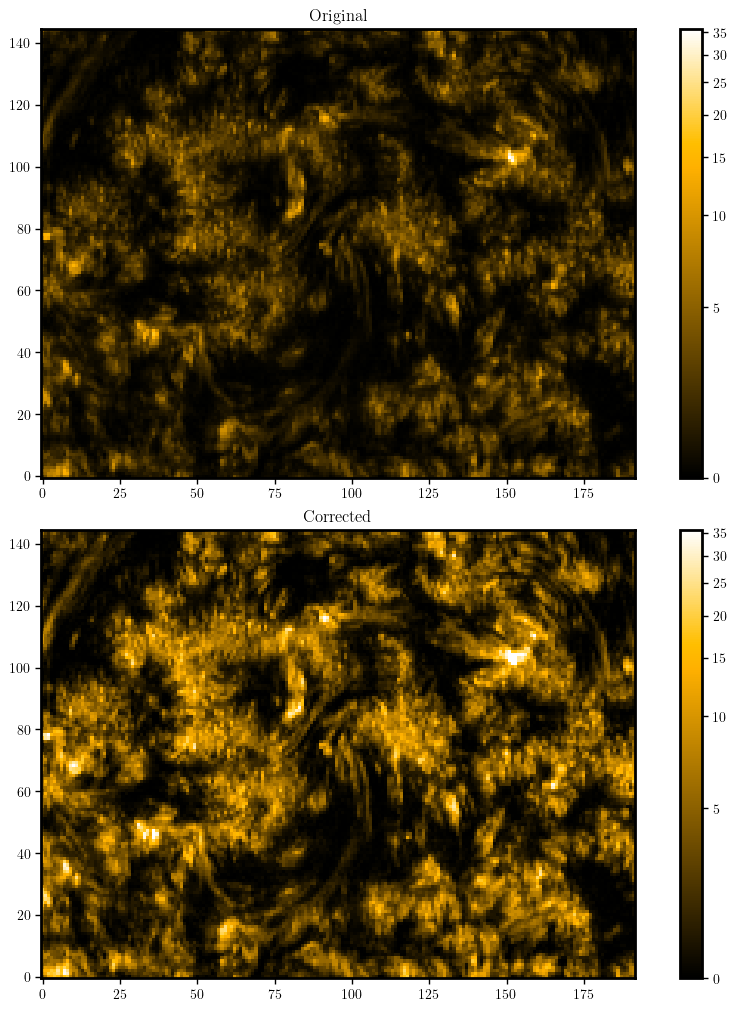

In [28]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

int_norm = ImageNormalize(stretch=AsinhStretch(0.1))

ax1.imshow(spice_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1,
           cmap="sdoaia171")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_fits["amplitudes"].T,origin="lower",norm=int_norm,aspect=1,
              cmap="sdoaia171")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")


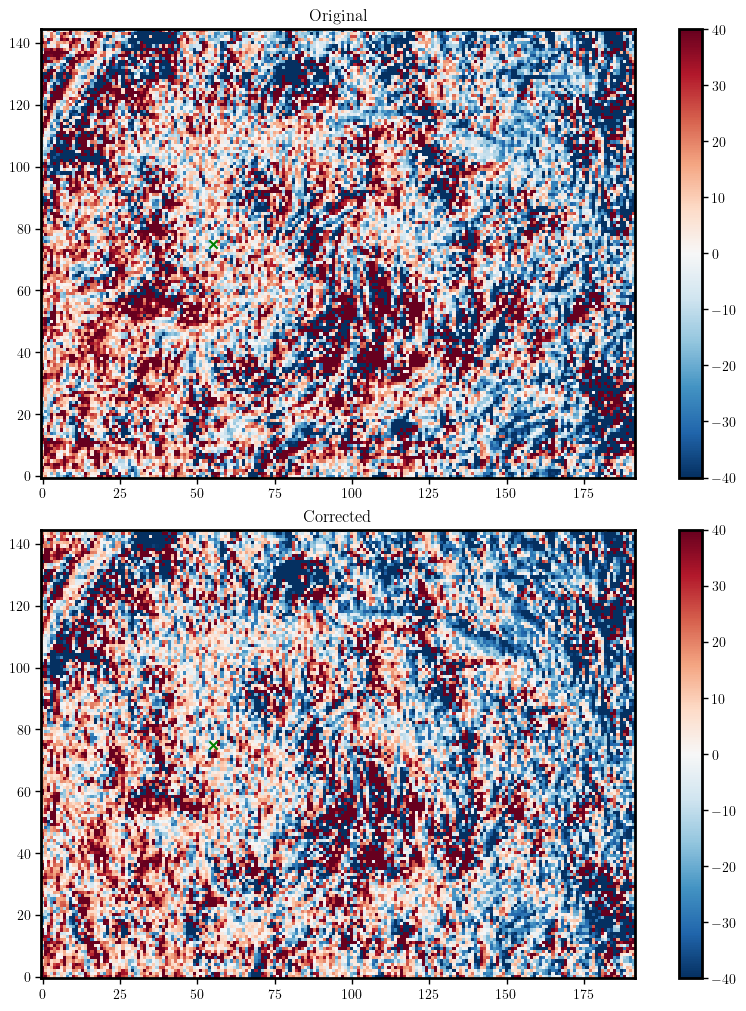

In [39]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),layout="constrained")

ax1.imshow(spice_origin_vel,origin="lower",vmin=-40,vmax=40,aspect=1,
           cmap="RdBu_r")
plt.colorbar(ax1.images[0],ax=ax1)
ax1.set_title("Original")

ax2.imshow(spice_corr_vel,origin="lower",vmin=-40,vmax=40,aspect=1,
                cmap="RdBu_r")
plt.colorbar(ax2.images[0],ax=ax2)
ax2.set_title("Corrected")

for ax_ in (ax1,ax2):
    ax_.scatter(55,75,color="green",marker="x")

In [30]:
NIV_765_window_wvl = spice_NIV_765_window.spectral_axis.to_value("Angstrom")
NIV_deconv_rebin_fitmodel = SpectrumFit2D(spice_corr_dat[:,:,17:34].transpose([1,0,2]).astype(np.float32), NIV_765_window_wvl[17:34],
                                line_number=1,line_wvl_init=[765],int_max_init=0.2,fwhm_init=1,
                                same_width=False)
NIV_deconv_rebin_fitmodel.run_lse_mp(prev_init=False)

/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/home/yjzhu/SOLAR/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will b

Doppler velocity corrected by the median of each raster.


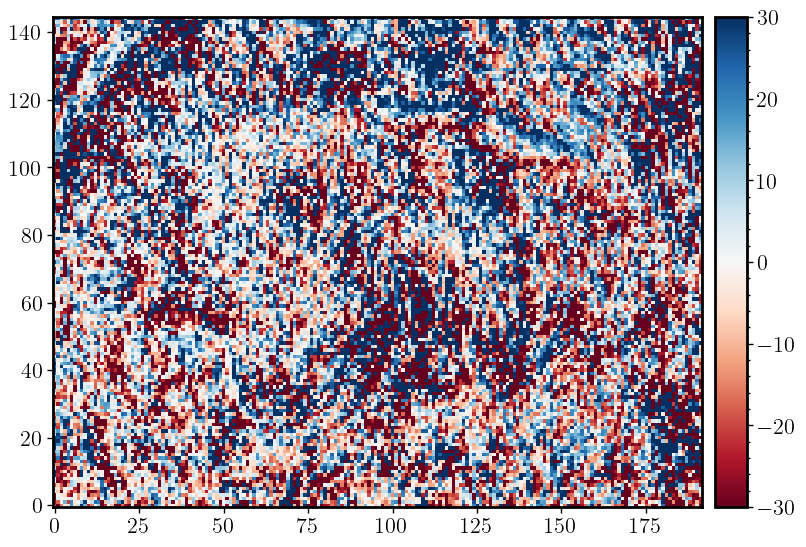

In [31]:
NIV_deconv_rebin_fitmodel.plot_fit2d(param="vel",vmin=-30,vmax=30,vel_corr="column",ref_wvl=770.03,   
                                    aspect=1,cmap="RdBu")

In [32]:
spice_corr_dat.shape

(192, 145, 50)

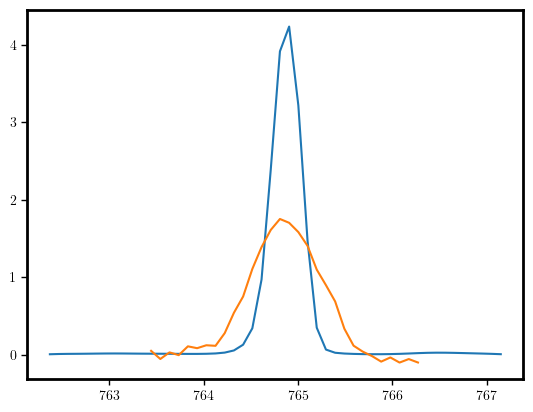

In [33]:
plt.plot(NIV_765_window_wvl, spice_corr_dat[145,50,:])
plt.plot(NIV_765_window_wvl, spice_dat1[145,50,:])

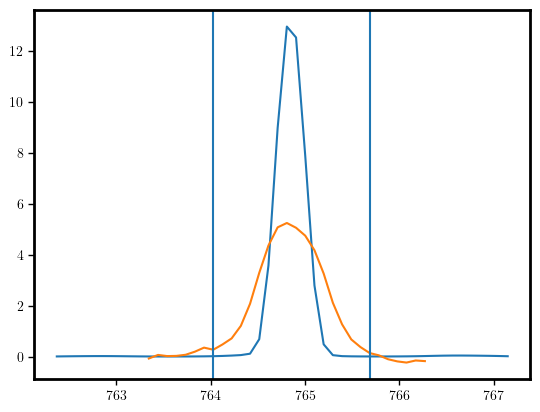

In [34]:
plt.plot(NIV_765_window_wvl, spice_corr_dat[60,62,:])
plt.plot(NIV_765_window_wvl, spice_dat1[60,62,:])
plt.axvline(NIV_765_window_wvl[17])
plt.axvline(NIV_765_window_wvl[34])

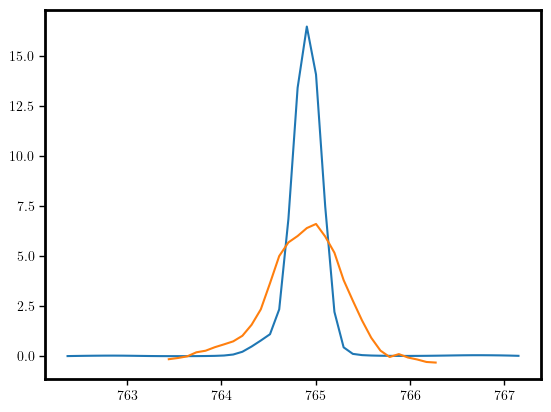

In [35]:
plt.plot(NIV_765_window_wvl, spice_corr_dat[75,55,:])
plt.plot(NIV_765_window_wvl, spice_dat1[75,55,:])

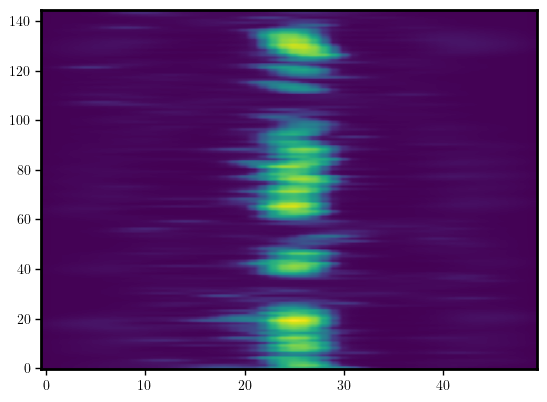

In [36]:
plt.imshow(spice_corr_dat[175,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))

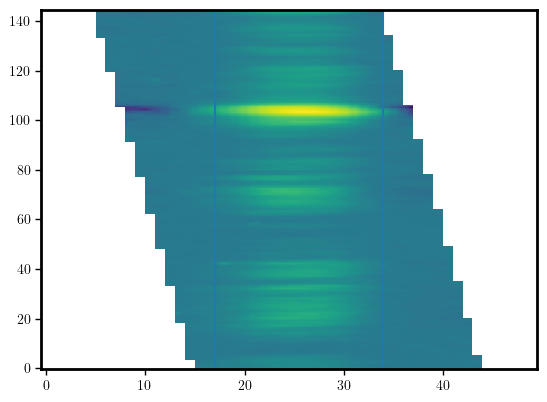

In [37]:
plt.imshow(spice_dat1[151,:,:],origin="lower",aspect=1/4,
           norm=ImageNormalize(stretch=AsinhStretch(0.01)))
plt.axvline(17)
plt.axvline(34)

In [38]:
spice_corr_dat.shape

(192, 145, 50)